In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import seaborn as sns
sns.set()

In [2]:
raw_data = pd.read_csv('car_sales.csv')
df = raw_data.copy()

#### Dropping Model column and null records

In [3]:
df = df.drop(columns='Model')
df = df.dropna(axis=0)

In [4]:
df.describe()

,Price,Mileage,EngineV,Year
count,4025.000000,4025.000000,4025.000000,4025.000000
mean,19552.308065,163.572174,2.764586,2006.379627
std,25815.734988,103.394703,4.935941,6.695595
min,600.000000,0.000000,0.600000,1969.000000
25%,6999.000000,90.000000,1.800000,2003.000000
50%,11500.000000,158.000000,2.200000,2007.000000
75%,21900.000000,230.000000,3.000000,2012.000000
max,300000.000000,980.000000,99.990000,2016.000000


#### Handling Outliers

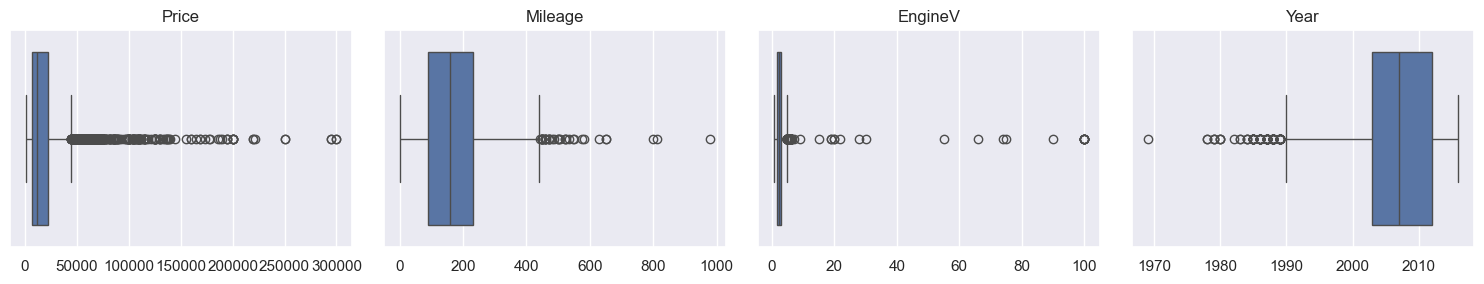

In [5]:
numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns

plt.subplots(1,4,figsize=(15,3))

for i, column in enumerate(numerical_columns, 1):
    plt.subplot(1, 4, i)
    sns.boxplot(x=df[column])
    plt.title(column)
    plt.xlabel('')

plt.tight_layout()
plt.show()

In [6]:
df_outliers = df.copy()

In [7]:
enginevuqr = df['EngineV'].quantile(.75)
enginevuqr

3.0

#### Reasoning for outliers

###### Price
Clearly the data includes some top-end cars, or some erroneous data. While it's not impossible that cars are being sold for $300,000, it seems less likely to be included in used car sales (although, having never bought, sold, or owned a luxury sports car, it's hard for me to say... do people just take these to local dealer when they've had their fun? It seems unlikely).

Will drop under 200k and log transform to stabilise variance.

###### Mileage
Average mileage per year in the UK is around 6,000 miles. I'd imagine this is higher in the US, so looking at the means from the data, an average mileage per year of around 8,500 miles is found. So, the scale is x1000. Again, it wouldn't be impossible for a 30yo car to do 1 million miles, but research shows that around 300,000 is seen as a very impressive milestone to reach, requiring proper care and maintenance to reach.

Apply cap at 500k.

###### EngineV
The Upper quartile range is exactly 3 here, engines above this size are less common, in the UK at least, but can easily get much higher.

Apply cap at 7.

##### Year
There are few outliers on the lower end of the data, so I'd feel comfortable using IQR here. Either they're classic cars with a higher value, which will distort the data, or they're just very old cars.

#### Price

In [8]:
df_outliers = df_outliers[df_outliers['Price'] <= 200000]

In [9]:
df_outliers.describe()

,Price,Mileage,EngineV,Year
count,4016.000000,4016.000000,4016.000000,4016.000000
mean,19010.518167,163.880229,2.757809,2006.364293
std,23108.950597,103.300955,4.939352,6.694509
min,600.000000,0.000000,0.600000,1969.000000
25%,6999.000000,90.000000,1.800000,2003.000000
50%,11500.000000,158.500000,2.200000,2007.000000
75%,21700.000000,230.000000,3.000000,2012.000000
max,200000.000000,980.000000,99.990000,2016.000000


#### Mileage

In [10]:
df_outliers = df_outliers[df_outliers['Mileage'] <= 500]

In [11]:
df_outliers.describe()

,Price,Mileage,EngineV,Year
count,4000.00000,4000.000000,4000.000000,4000.000000
mean,19033.08524,162.064750,2.759490,2006.390500
std,23124.48087,99.082001,4.948941,6.676425
min,600.00000,0.000000,0.600000,1969.000000
25%,6999.75000,90.000000,1.800000,2003.000000
50%,11500.00000,158.000000,2.200000,2007.500000
75%,21700.00000,230.000000,3.000000,2012.000000
max,200000.00000,500.000000,99.990000,2016.000000


#### EngineV

In [12]:
df_outliers = df_outliers[df_outliers['EngineV'] <= 7]

In [13]:
df_outliers.describe()

,Price,Mileage,EngineV,Year
count,3978.000000,3978.000000,3978.000000,3978.000000
mean,19097.339105,161.866264,2.460742,2006.406737
std,23169.081300,99.127441,0.964430,6.675983
min,600.000000,0.000000,0.600000,1969.000000
25%,7000.000000,90.000000,1.800000,2003.000000
50%,11500.000000,157.000000,2.200000,2008.000000
75%,21875.000000,230.000000,3.000000,2012.000000
max,200000.000000,500.000000,6.500000,2016.000000


#### Year

In [14]:
df_year = df_outliers.copy()

q1 = df_year['Year'].quantile(.25)
q3 = df_year['Year'].quantile(.75)

IQR = q3 - q1

df_year = df_year[df_year['Year'] >= q1 - 1.5 * IQR]

In [15]:
df_year.describe()

,Price,Mileage,EngineV,Year
count,3881.000000,3881.000000,3881.000000,3881.000000
mean,19498.770964,160.040196,2.472077,2006.911878
std,23308.938316,97.476806,0.969875,5.912460
min,800.000000,0.000000,0.600000,1990.000000
25%,7300.000000,90.000000,1.800000,2003.000000
50%,11800.000000,156.000000,2.200000,2008.000000
75%,22000.000000,225.000000,3.000000,2012.000000
max,200000.000000,500.000000,6.500000,2016.000000


In [16]:
df_year.head()

,Brand,Price,Body,Mileage,EngineV,Engine Type,Registration,Year
0,BMW,4200.0,sedan,277,2.0,Petrol,yes,1991
1,Mercedes-Benz,7900.0,van,427,2.9,Diesel,yes,1999
2,Mercedes-Benz,13300.0,sedan,358,5.0,Gas,yes,2003
3,Audi,23000.0,crossover,240,4.2,Petrol,yes,2007
4,Toyota,18300.0,crossover,120,2.0,Petrol,yes,2011


In [17]:
df_year.reset_index(drop=True)

,Brand,Price,Body,Mileage,EngineV,Engine Type,Registration,Year
0,BMW,4200.0,sedan,277,2.0,Petrol,yes,1991
1,Mercedes-Benz,7900.0,van,427,2.9,Diesel,yes,1999
2,Mercedes-Benz,13300.0,sedan,358,5.0,Gas,yes,2003
3,Audi,23000.0,crossover,240,4.2,Petrol,yes,2007
4,Toyota,18300.0,crossover,120,2.0,Petrol,yes,2011
...,...,...,...,...,...,...,...,...
3876,Volkswagen,11500.0,van,163,2.5,Diesel,yes,2008
3877,Toyota,17900.0,sedan,35,1.6,Petrol,yes,2014
3878,Mercedes-Benz,125000.0,sedan,9,3.0,Diesel,yes,2014
3879,BMW,6500.0,sedan,1,3.5,Petrol,yes,1999


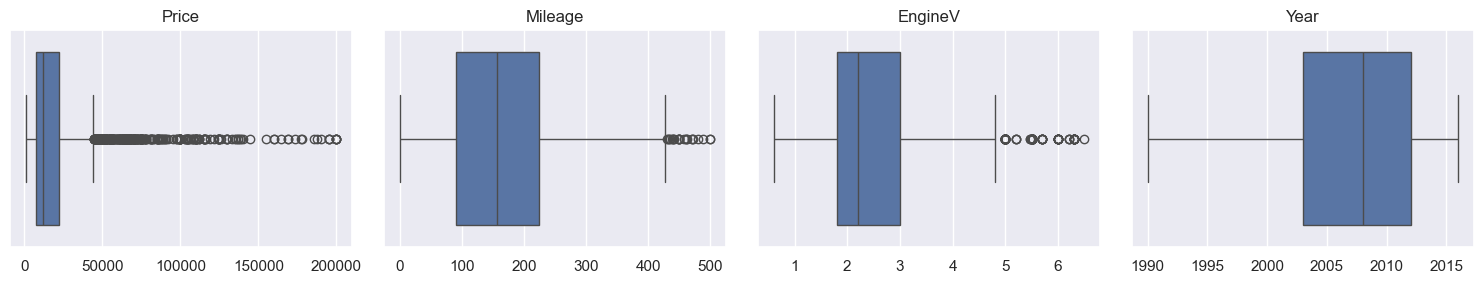

In [18]:
numerical_columns = df_year.select_dtypes(include=['float64', 'int64']).columns

plt.subplots(1,4,figsize=(15,3))

for i, column in enumerate(numerical_columns, 1):
    plt.subplot(1, 4, i)
    sns.boxplot(x=df_year[column])
    plt.title(column)
    plt.xlabel('')

plt.tight_layout()
plt.show()

#### Evaluation

Boxplots look far better now, except for price, will check again for log_price

In [19]:
df = df_year.copy()

#### Checking OLS

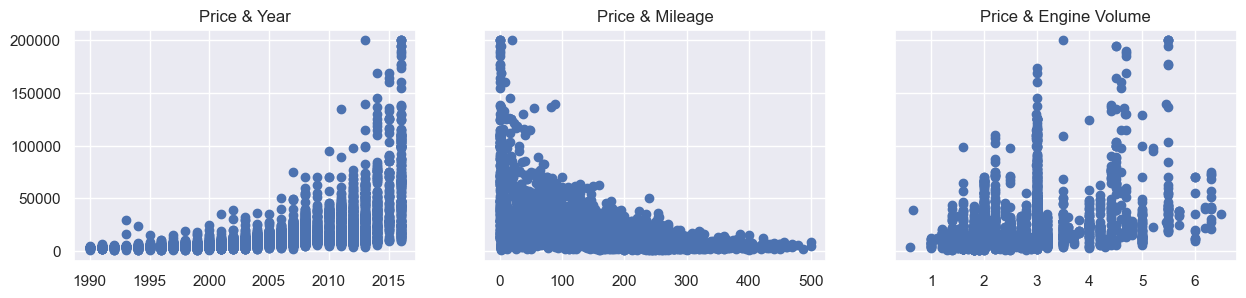

In [20]:
f, (ax1, ax2, ax3) = plt.subplots(1,3,sharey=True, figsize=(15,3))
ax1.scatter(df['Year'],df['Price'])
ax1.set_title('Price & Year')
ax2.scatter(df['Mileage'],df['Price'])
ax2.set_title('Price & Mileage')
ax3.scatter(df['EngineV'],df['Price'])
ax3.set_title('Price & Engine Volume')

plt.show()

In [21]:
log_price = np.log(df['Price'])
df['log_price'] = log_price
df.head()

,Brand,Price,Body,Mileage,EngineV,Engine Type,Registration,Year,log_price
0,BMW,4200.0,sedan,277,2.0,Petrol,yes,1991,8.342840
1,Mercedes-Benz,7900.0,van,427,2.9,Diesel,yes,1999,8.974618
2,Mercedes-Benz,13300.0,sedan,358,5.0,Gas,yes,2003,9.495519
3,Audi,23000.0,crossover,240,4.2,Petrol,yes,2007,10.043249
4,Toyota,18300.0,crossover,120,2.0,Petrol,yes,2011,9.814656


<Axes: xlabel='log_price'>

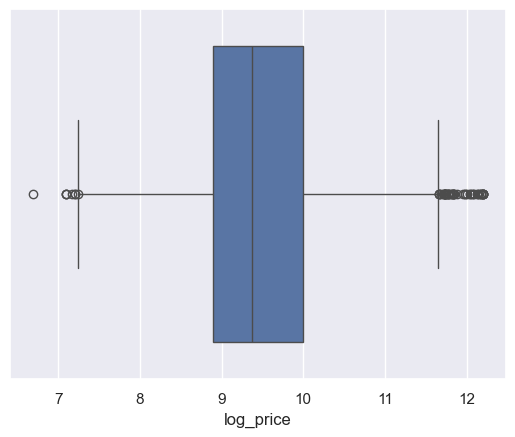

In [22]:
sns.boxplot(x=df['log_price'])

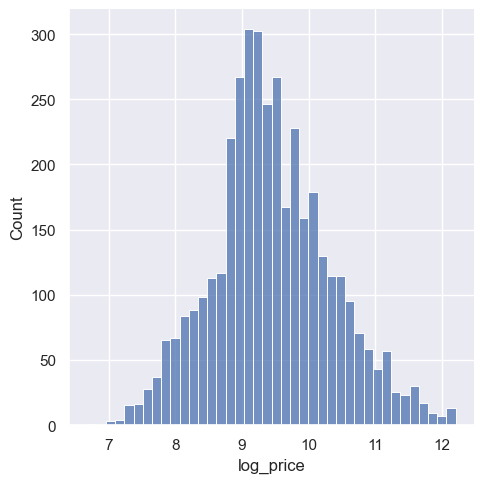

In [23]:
sns.displot(df['log_price'])

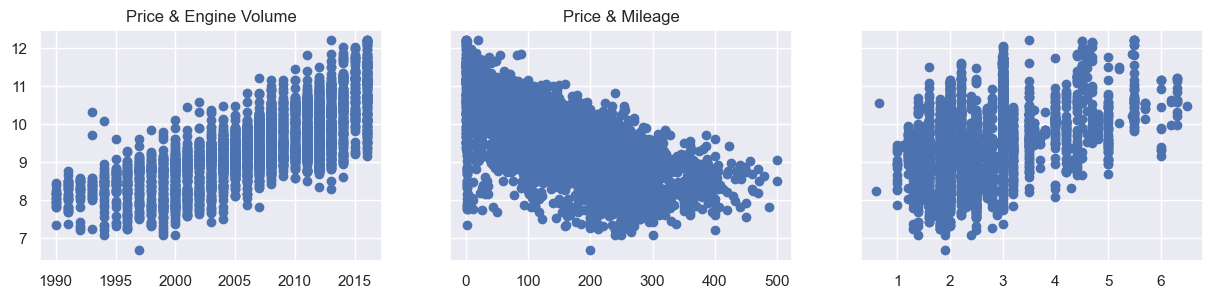

In [24]:
f, (ax1, ax2, ax3) = plt.subplots(1,3,sharey=True, figsize=(15,3))
ax1.scatter(df['Year'],df['log_price'])
ax1.set_title('Price & Year')
ax2.scatter(df['Mileage'],df['log_price'])
ax2.set_title('Price & Mileage')
ax3.scatter(df['EngineV'],df['log_price'])
ax1.set_title('Price & Engine Volume')

plt.show()

In [25]:
df_log = df.drop(columns='Price')

#### Checkpoint

Will probably make mistakes from here on out, so let's get some checkpoints going

In [26]:
df_dummy_check = df.copy()

#### Dummies

In [27]:
numerical = df.select_dtypes(include=['float64', 'int64'])
categorical = df.select_dtypes(include=['object','category'])

dummy = pd.concat([numerical, pd.get_dummies(categorical, drop_first=True).astype(int)], axis=1)
dummy.head()

,Price,Mileage,EngineV,Year,log_price,Brand_BMW,Brand_Mercedes-Benz,Brand_Mitsubishi,Brand_Renault,Brand_Toyota,Brand_Volkswagen,Body_hatch,Body_other,Body_sedan,Body_vagon,Body_van,Engine Type_Gas,Engine Type_Other,Engine Type_Petrol,Registration_yes
0,4200.0,277,2.0,1991,8.342840,1,0,0,0,0,0,0,0,1,0,0,0,0,1,1
1,7900.0,427,2.9,1999,8.974618,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1
2,13300.0,358,5.0,2003,9.495519,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1
3,23000.0,240,4.2,2007,10.043249,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
4,18300.0,120,2.0,2011,9.814656,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1


In [28]:
df = dummy.copy()

#### F-Reg

In [29]:
from sklearn.feature_selection import f_regression

In [30]:
df.columns

Index(['Price', 'Mileage', 'EngineV', 'Year', 'log_price', 'Brand_BMW',
       'Brand_Mercedes-Benz', 'Brand_Mitsubishi', 'Brand_Renault',
       'Brand_Toyota', 'Brand_Volkswagen', 'Body_hatch', 'Body_other',
       'Body_sedan', 'Body_vagon', 'Body_van', 'Engine Type_Gas',
       'Engine Type_Other', 'Engine Type_Petrol', 'Registration_yes'],
      dtype='object')

In [31]:
df = df.drop(columns='Price')

In [32]:
targets = df['log_price']
features = df[['Mileage', 'EngineV', 'Year', 'Brand_BMW',
       'Brand_Mercedes-Benz', 'Brand_Mitsubishi', 'Brand_Renault',
       'Brand_Toyota', 'Brand_Volkswagen', 'Body_hatch', 'Body_other',
       'Body_sedan', 'Body_vagon', 'Body_van', 'Engine Type_Gas',
       'Engine Type_Other', 'Engine Type_Petrol', 'Registration_yes']]

In [33]:
f_stats, p_stats = f_regression(features,targets)

In [34]:
freg_summary = pd.DataFrame(data=features.columns.values, columns=['Features'])

In [35]:
freg_summary['p_values'] = p_stats.round(3)

In [36]:
freg_summary

,Features,p_values
0,Mileage,0.000
1,EngineV,0.000
2,Year,0.000
3,Brand_BMW,0.000
4,Brand_Mercedes-Benz,0.000
5,Brand_Mitsubishi,0.000
6,Brand_Renault,0.000
7,Brand_Toyota,0.000
8,Brand_Volkswagen,0.000
9,Body_hatch,0.000


#### VIF Check

In [37]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(features.values, i) for i in range(features.shape[1])]
vif['Features'] = features.columns
vif

,VIF,Features
0,4.663189,Mileage
1,12.001178,EngineV
2,44.188968,Year
3,2.620111,Brand_BMW
4,3.189111,Brand_Mercedes-Benz
5,1.952237,Brand_Mitsubishi
6,2.450522,Brand_Renault
7,2.495890,Brand_Toyota
8,3.461293,Brand_Volkswagen
9,1.666593,Body_hatch


In [38]:
features_2 = features.drop(columns='Year')

In [39]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(features_2.values, i) for i in range(features_2.shape[1])]
vif['features_2'] = features_2.columns
vif

,VIF,features_2
0,4.312197,Mileage
1,7.790747,EngineV
2,2.287717,Brand_BMW
3,2.956077,Brand_Mercedes-Benz
4,1.639358,Brand_Mitsubishi
5,2.090909,Brand_Renault
6,2.173361,Brand_Toyota
7,2.843048,Brand_Volkswagen
8,1.447896,Body_hatch
9,1.529809,Body_other


#### Dropping Year

I'll come back to here in order to check it, but the work I've done with the outliers has shot the VIF for year up to 44.

In [40]:
df = df.drop(columns='Year')

In [41]:
features = features_2.copy()

In [42]:
df.head()

,Mileage,EngineV,log_price,Brand_BMW,Brand_Mercedes-Benz,Brand_Mitsubishi,Brand_Renault,Brand_Toyota,Brand_Volkswagen,Body_hatch,Body_other,Body_sedan,Body_vagon,Body_van,Engine Type_Gas,Engine Type_Other,Engine Type_Petrol,Registration_yes
0,277,2.0,8.342840,1,0,0,0,0,0,0,0,1,0,0,0,0,1,1
1,427,2.9,8.974618,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1
2,358,5.0,9.495519,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1
3,240,4.2,10.043249,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
4,120,2.0,9.814656,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1


In [43]:
df.columns

Index(['Mileage', 'EngineV', 'log_price', 'Brand_BMW', 'Brand_Mercedes-Benz',
       'Brand_Mitsubishi', 'Brand_Renault', 'Brand_Toyota', 'Brand_Volkswagen',
       'Body_hatch', 'Body_other', 'Body_sedan', 'Body_vagon', 'Body_van',
       'Engine Type_Gas', 'Engine Type_Other', 'Engine Type_Petrol',
       'Registration_yes'],
      dtype='object')

In [44]:
cols = ['log_price', 'Mileage', 'EngineV', 'Brand_BMW', 'Brand_Mercedes-Benz',
       'Brand_Mitsubishi', 'Brand_Renault', 'Brand_Toyota', 'Brand_Volkswagen',
       'Body_hatch', 'Body_other', 'Body_sedan', 'Body_vagon', 'Body_van',
       'Engine Type_Gas', 'Engine Type_Other', 'Engine Type_Petrol',
       'Registration_yes']

df = df[cols]

In [45]:
df.head()

,log_price,Mileage,EngineV,Brand_BMW,Brand_Mercedes-Benz,Brand_Mitsubishi,Brand_Renault,Brand_Toyota,Brand_Volkswagen,Body_hatch,Body_other,Body_sedan,Body_vagon,Body_van,Engine Type_Gas,Engine Type_Other,Engine Type_Petrol,Registration_yes
0,8.342840,277,2.0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,1
1,8.974618,427,2.9,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1
2,9.495519,358,5.0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1
3,10.043249,240,4.2,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
4,9.814656,120,2.0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1


In [46]:
features.head()

,Mileage,EngineV,Brand_BMW,Brand_Mercedes-Benz,Brand_Mitsubishi,Brand_Renault,Brand_Toyota,Brand_Volkswagen,Body_hatch,Body_other,Body_sedan,Body_vagon,Body_van,Engine Type_Gas,Engine Type_Other,Engine Type_Petrol,Registration_yes
0,277,2.0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,1
1,427,2.9,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1
2,358,5.0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1
3,240,4.2,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
4,120,2.0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1


#### Scaling

In [47]:
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()

In [48]:
scaler.fit(features)

StandardScaler()

In [49]:
scaled_features = scaler.transform(features)
scaled_features

array([[ 1.20002778, -0.48680257,  2.2890063 , ..., -0.16095144,
         1.32676786,  0.32170996],
       [ 2.73905367,  0.4412717 , -0.43687079, ..., -0.16095144,
        -0.75371136,  0.32170996],
       [ 2.03110176,  2.60677833, -0.43687079, ..., -0.16095144,
        -0.75371136,  0.32170996],
       ...,
       [-1.54969848,  0.54439106, -0.43687079, ..., -0.16095144,
        -0.75371136,  0.32170996],
       [-1.63177986,  1.05998788,  2.2890063 , ..., -0.16095144,
         1.32676786,  0.32170996],
       [-0.36977863, -0.48680257, -0.43687079, ..., -0.16095144,
        -0.75371136,  0.32170996]])

#### TT Split

In [50]:
from sklearn.model_selection import train_test_split

In [51]:
x_train, x_test, y_train, y_test = train_test_split(scaled_features, targets, test_size=0.2, random_state=42)

#### Regression

In [52]:
reg = LinearRegression()

In [53]:
reg.fit(x_train, y_train)

LinearRegression()

In [54]:
r2 = reg.score(x_train,y_train)
n = x_train.shape[0]
p = x_train.shape[1]
r2

0.768966849591526

In [55]:
r2adj = 1 - (1 - r2) * (n-1) / (n-p-1)
r2adj

0.7676941459113755

#### Adjusted $R^2$ is slightly higher (

Will reinclude Year and proceed

Forgot about this, but Registration also had a fairly high VIF, and the majority of data points are yes, so it's worth removing this too!

In [56]:
df = dummy.copy()

In [57]:
df = df.drop(columns=['Price', 'Registration_yes'])

In [58]:
df.head()

,Mileage,EngineV,Year,log_price,Brand_BMW,Brand_Mercedes-Benz,Brand_Mitsubishi,Brand_Renault,Brand_Toyota,Brand_Volkswagen,Body_hatch,Body_other,Body_sedan,Body_vagon,Body_van,Engine Type_Gas,Engine Type_Other,Engine Type_Petrol
0,277,2.0,1991,8.342840,1,0,0,0,0,0,0,0,1,0,0,0,0,1
1,427,2.9,1999,8.974618,0,1,0,0,0,0,0,0,0,0,1,0,0,0
2,358,5.0,2003,9.495519,0,1,0,0,0,0,0,0,1,0,0,1,0,0
3,240,4.2,2007,10.043249,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,120,2.0,2011,9.814656,0,0,0,0,1,0,0,0,0,0,0,0,0,1


In [59]:
cols = ['log_price', 'Mileage', 'EngineV', 'Year', 'Brand_BMW', 'Brand_Mercedes-Benz',
       'Brand_Mitsubishi', 'Brand_Renault', 'Brand_Toyota', 'Brand_Volkswagen',
       'Body_hatch', 'Body_other', 'Body_sedan', 'Body_vagon', 'Body_van',
       'Engine Type_Gas', 'Engine Type_Other', 'Engine Type_Petrol']

df = df[cols]

In [60]:
target = df['log_price']
features = df[['Mileage', 'EngineV', 'Year', 'Brand_BMW',
       'Brand_Mercedes-Benz', 'Brand_Mitsubishi', 'Brand_Renault',
       'Brand_Toyota', 'Brand_Volkswagen', 'Body_hatch', 'Body_other',
       'Body_sedan', 'Body_vagon', 'Body_van', 'Engine Type_Gas',
       'Engine Type_Other', 'Engine Type_Petrol']]

In [70]:
scaler2 = StandardScaler()

In [71]:
scaler2.fit(features)

StandardScaler()

In [72]:
features_scaled2 = scaler2.transform(features)

In [73]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(scaled_features, targets, test_size=0.2, random_state=42)

In [74]:
reg2 = LinearRegression()

In [75]:
reg2.fit(x_train, y_train)

LinearRegression()

In [76]:
r2 = reg2.score(x_train,y_train)
n = x_train.shape[0]
p = x_train.shape[1]
r2

0.768966849591526

In [77]:
r2adj = 1 - (1 - r2) * (n-1) / (n-p-1)
r2adj

0.7676941459113755

In [78]:
y_hat = reg.predict(x_train)